# Sensitivity study on the nonlinear analysis' parameters
This Jupyter notebook investigates the effect of varying the parameters of MSC Natran's SOL 106 nonlinear analysis on the load-displacement diagram of a box beam structure under a bending load.

## Problem definition

***

### Geometry

In [9]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


### Material

In [10]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

### Mesh and boundary conditions

We choose the edge length of the shell elements based on the mesh convergence results of the previous notebook.

In [11]:
from resources import box_beam_utils

edge_length = 33  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]
  SPC1:    1

bdf.params
  PARAM    : 1

bdf.nodes
  GRID     : 9248

bdf.elements
  CQUAD4   : 9180

bdf.properties
  PSHELL   : 1

bdf.materials
  MAT1     : 1




subcase=0 already exists...skipping


### Load

Define applied load.

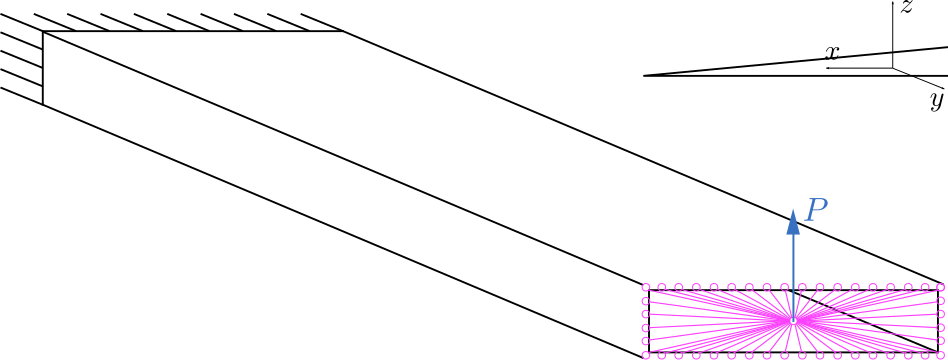

In [12]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [13]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])
# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)
# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    9249              1.      0.      0.      1.

Let's calculate the linear buckling load.

Buckling load: 1656 N
Buckling shape:


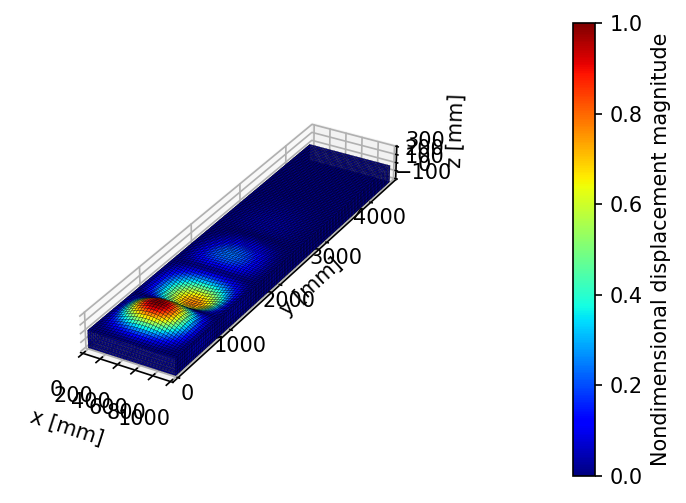

In [14]:
import matplotlib.pyplot as plt

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Define name of analysis directory
analysis_directory_name = '05_Sensitivity_Study_Nonlinear_Analysis_Parameters'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Calculate linear buckling load and plot shape
input_name = 'linear_buckling'
sol105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=box_beam_bdf_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=True, plot_shape=True)

## Nonlinear analysis

Set up nonlinear analysis solution sequence with default parameters and define applied load equal to buckling load predicted by SOL 105.

In [15]:
from resources import pynastran_utils

# Setup SOL 106 with default nonlinear analysis parameters
box_beam_utils.set_up_sol_106(box_beam_bdf_input)
# Define applied load and related subcase
load_set_id = force_set_id+1
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[sol105_buckling_load], load_ids=[force_set_id])
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1, load_set_id=load_set_id)

Runa analysis and plot load-displacement diagram.

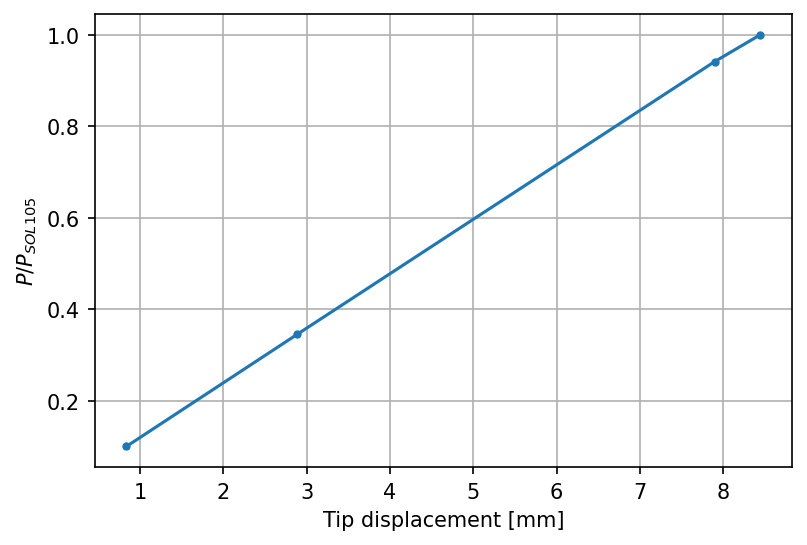

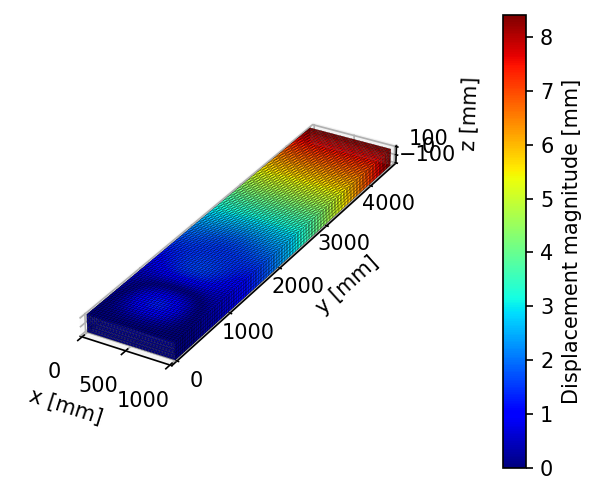

In [16]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_filename = 'nonlinear_analysis_reference'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, bdf_filename=input_filename, run_flag=True)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot structural deformation
pynastran_utils.plot_displacements(op2_object=op2_output)

## NLPARM fields

***

Let's define a function to read load and displacement history and plot it on an existent figure.

In [17]:
def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, bdf_filename=input_filename, run_flag=True)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=False)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], p[1][:, load_component_index]/sol105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

Define a list of marker characters that we will use to plot the various load-displacement curves.

In [18]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Get list of marker characters
markers = list(Line2D.markers.keys())[2:]
# Find id of NLPARM card
nlparm_id = next(iter(box_beam_bdf_input.nlparms))

Variation of error functions.

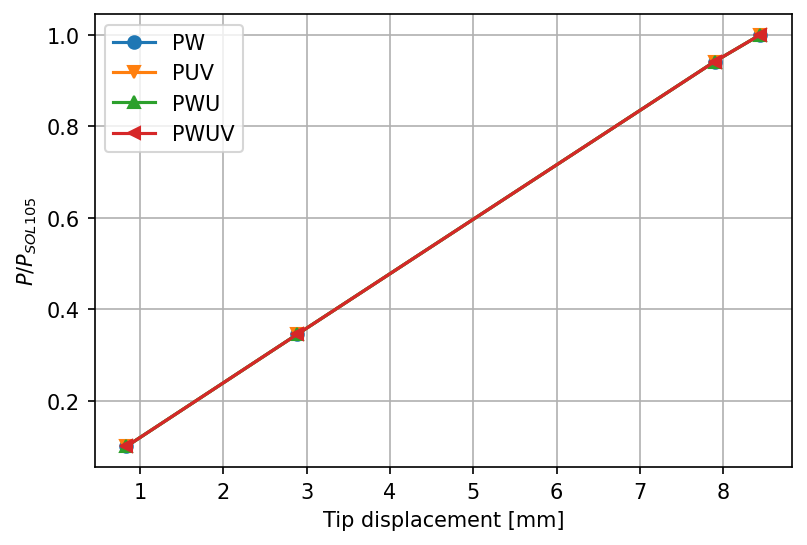

In [19]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']
# Create figure
_, ax = plt.subplots()
# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'{fun}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

Variation of convergence tolerances.

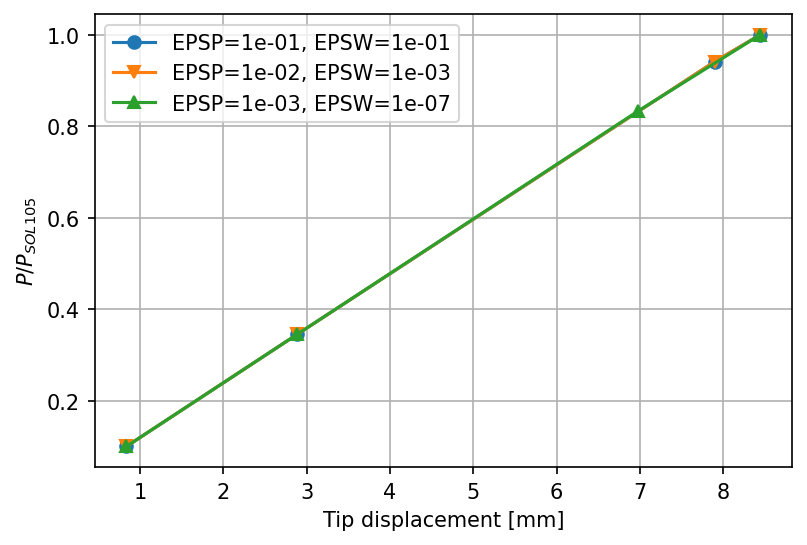

In [20]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]
# Restore default for error function
box_beam_bdf_input.nlparms[nlparm_id].conv = 'PW'
# Create figure
_, ax = plt.subplots()
# Run analysis for each couple of convergence tolerances and plot load-displacement diagram
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.3f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

Variation of initial load increment.

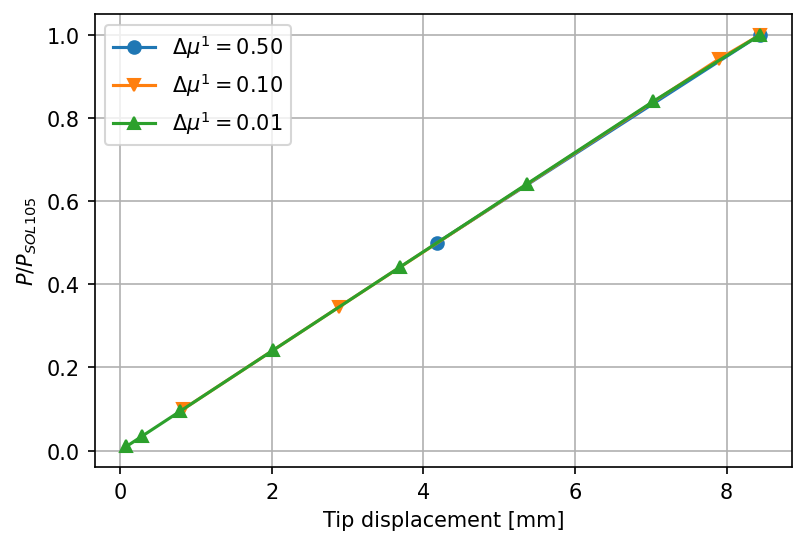

In [21]:
# Define initial load increments
initial_load_increments = [.5, .1, .01]
# Restore default for convergence tolerances
box_beam_bdf_input.nlparms[nlparm_id].eps_p = 1e-2
box_beam_bdf_input.nlparms[nlparm_id].eps_w = 1e-2
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

## NLPCI fields
Variation of desired number of iterations.

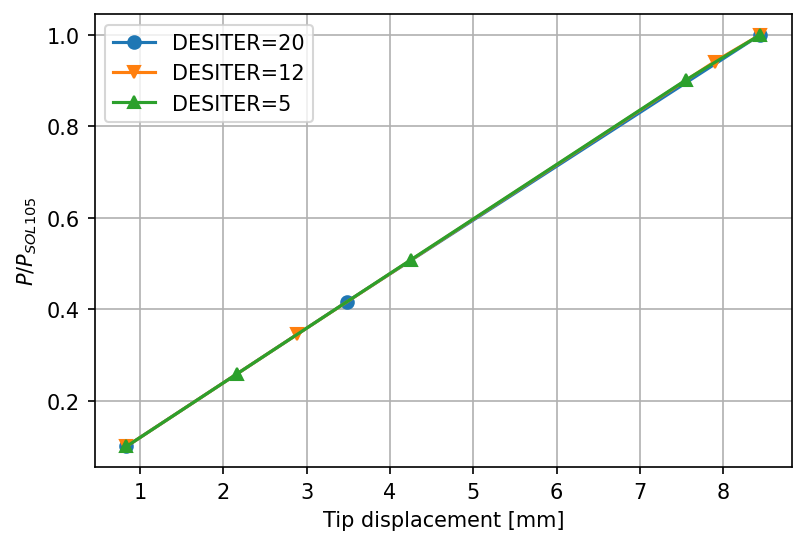

In [22]:
# Define desired numbers of iterations
no_iterations = [20, 12, 5]
# Restore default initial load increment
box_beam_bdf_input.nlparms[nlparm_id].ninc = 10
# Create figure
_, ax = plt.subplots()
# Run analysis for each desired number of iterations and plot load-displacement diagram
for count, desiter in enumerate(no_iterations):
    box_beam_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = 'nonlinear_analysis_desiter_' + str(desiter)
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'DESITER={desiter}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

Variation of minimum allowable arc-length adjustment ratio.

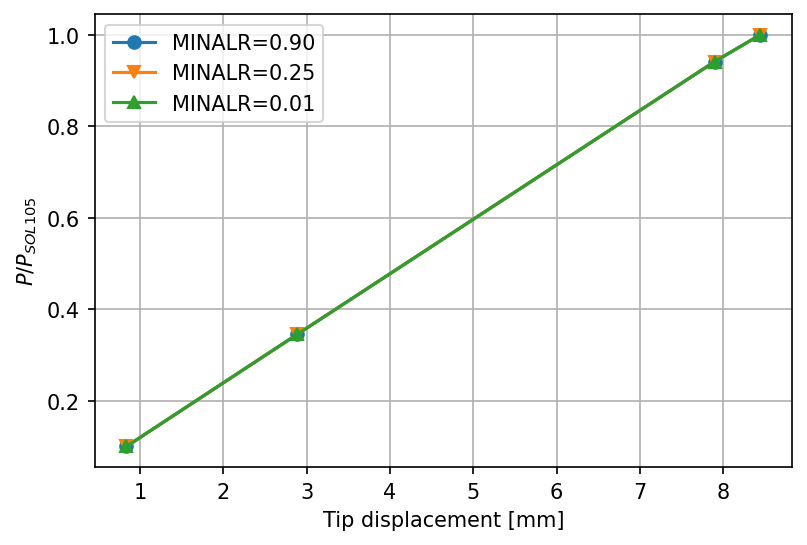

In [23]:
# Define minimum allowable arc-length adjustment ratios
min_arclength_adjustment_ratios = [.9, .25, .01]
# Restore default desired number of iterations
box_beam_bdf_input.nlpcis[nlparm_id].desiter = 12
# Create figure
_, ax = plt.subplots()
# Run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].minalr = minalr
    input_filename = f'nonlinear_analysis_minalr_{minalr:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MINALR={minalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

Variation of maximum allowable arc-length adjustment ratio.

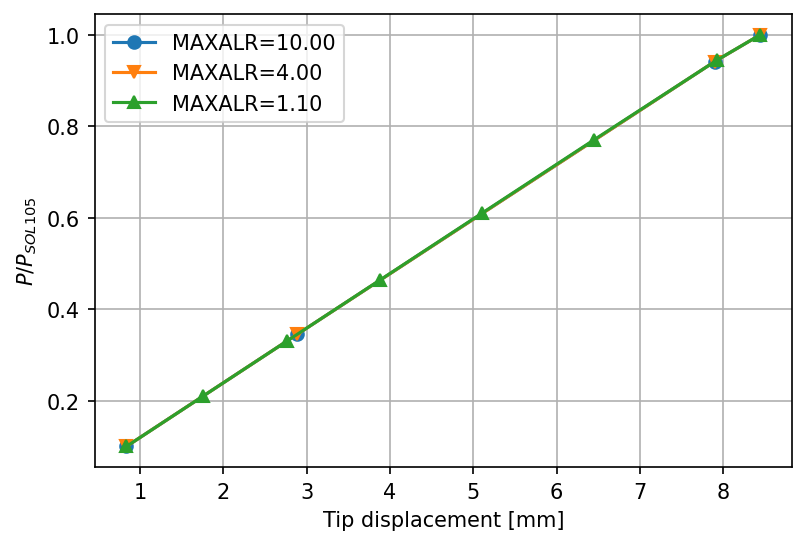

In [24]:
# Define maximum allowable arc-length adjustment ratios
max_arclength_adjustment_ratios = [10., 4., 1.1]
# Restore default minimum allowable arc-length adjustment ratios
box_beam_bdf_input.nlpcis[nlparm_id].minalr = .25
# Create figure
_, ax = plt.subplots()
# Run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].maxalr = maxalr
    input_filename = f'nonlinear_analysis_maxalr_{maxalr:.1f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MAXALR={maxalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [25]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()